<center><h1>Rhythm and Timbre Analysis from Music</h1></center>
<center><h2>Rhythm Pattern Music Features</h2></center>
<center><h2>Extraction and Application Tutorial</h2></center>
<br>
<center><h3>Thomas Lidy and Alexander Schindler</h3><br><b>Institute of Software Technology and Interactive Systems<br>TU Wien
<br>
<center><h3>http://www.ifs.tuwien.ac.at/mir</h3></center>
<br>
<br>

## Table of Contents

1. <a href="#requirements">Requirements</a>
2. <a href="#processing">Audio Processing</a>
3. <a href="#extraction">Audio Feature Extraction</a>
4. <a href="#application">Application Scenarios</a><br>
    4.1. <a href="#similar">Finding Similar Sounding Songs</a>



# <a name="requirements"><font color="#0404B4">1. Requirements</font></a>

This Tutorial uses iPython Notebook for interactive coding. If you use iPython Notebook, you can interactively execute your code (and the code here in the tutorial) directly in the Web browser. Otherwise you can copy & paste code from here to your prefered Python editor.

In [ ]:
# to install iPython notebook on your computer, use this in Terminal
sudo pip install "ipython[notebook]"

### RP Extract Library

This is our mean library for rhythmic and timbral audio feature analysis:

<ul>
<li><a href="https://github.com/tuwien-musicir/rp_extract">RP_extract</a> Rhythm Patterns Audio Feature Extraction Library (includes <a href="https://github.com/WarrenWeckesser/wavio">Wavio</a> for reading wav files (incl. 24 bit)) </li>
</ul>

download <a href="https://github.com/tuwien-musicir/rp_extract/archive/master.zip">ZIP</a> or check out from GitHub:

In [ ]:
# in Terminal
git clone https://github.com/tuwien-musicir/rp_extract.git

### Python Libraries

RP_extract depends on the following libraries. If not already included in your Python installation,
please install these Python libraries using pip or easy_install:

<ul>
<li><a href="http://www.numpy.org/">Numpy</a>: the fundamental package for scientific computing with Python. It implements a wide range of fast and powerful algebraic functions.</li>
<li><a href="http://www.scipy.org/install.html">Scipy</a>: Scientific Python library</li>
<!-- <li><a href="https://pypi.python.org/pypi/scikits.talkbox/0.2.5">scikits.talkbox</a>: Talkbox, python modules for speech/signal processing</li>-->
</ul> 

They can usually be installed via Python PIP installer on command line:

In [ ]:
# in Terminal
sudo pip install numpy scipy

### Additional Libraries 

These libraries are used in the later tutorial steps, but not necessarily needed if you want to use the RP_extract library alone:

<ul>
<li><a href="https://github.com/tuwien-musicir/mir_utils">mir_utils</a>: these are additional functions used for the Soundcloud Demo data set in the tutorial below</li>
<li><a href="https://developers.soundcloud.com">Soundcloud API</a>: used to retrieve and analyze music from Soundcloud.com</li>
<li><a href="https://pypi.python.org/pypi/unicsv/1.0.0">unicsv</a>: used in rp_extract_files.py for batch iteration over many wav or mp3 files, and storing features in CSV (only needed when you want to do batch feature extraction to CSV)</li>
<li><a href="http://scikit-learn.org/stable/">sklearn</a>: Scikit-Learn machine learning package - used in later tutorial steps for finding similar songs and/or using machine learning / classification
</ul>

In [ ]:
# in Terminal
git clone https://github.com/tuwien-musicir/mir_utils.git
sudo pip install soundcloud unicsv scikit-learn

### MP3 Decoder
If you want to use MP3 files as input, you need to have one of the following MP3 decoders installed in your system:

<ul>
<li>Windows: FFMpeg (ffmpeg.exe is included in RP_extract library on Github above, nothing to install)</li>
<li>Mac: <a href="http://www.thalictrum.com/en/products/lame.html">Lame for Mac</a> or <a href="http://ffmpegmac.net">FFMPeg for Mac</a></li>
<li>Linux: please install mpg123, lame or ffmpeg from your Software Install Center or Package Repository</li>
</ul>

Note: If you don't install it to a path which can be found by the operating system, use this to add path where you installed the MP3 decoder binary to your system PATH so Python can call it:

In [12]:
import os
path = '/path/to/ffmpeg/'
os.environ['PATH'] += os.pathsep + path

### Import + Test your Environment
If you have installed all required libraries, the follwing imports should run without errors.

In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# numerical processing and scientific libraries
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# Rhythm Pattern Audio Extraction Library
## edit the path here where you checked out and stored the rp_extract package
#import sys
#sys.path.append("./rp_extract")
from rp_plot import *
from rp_extract_python import rp_extract

# reading wav and mp3 files
from audiofile_read import *

# misc
from urllib import urlopen
import urllib2
import gzip
import StringIO

Populating the interactive namespace from numpy and matplotlib


# <a name="processing"><font color="#0404B4">2. Audio Processing</font></a>

Feature Extraction is the core of content-based description of audio files. With feature extraction from audio, a computer is able to recognize the content of a piece of music without the need of annotated labels such as artist, song title or genre. This is the essential basis for information retrieval tasks, such as similarity based searches (query-by-example, query-by-humming, etc.), automatic classification into categories, or automatic organization and clustering of music archives.

Content-based description requires the development of feature extraction techniques that analyze the acoustic characteristics of the signal. Features extracted from the audio signal are intended to describe the stylistic content of the music, e.g. beat, presence of voice, timbre, etc.

We use methods from digital signal processing and consider psycho-acoustic models in order to extract suitable semantic information from music. We developed various feature sets, which are appropriate for different tasks.

## Load Audio Files

### Load audio data from wav or mp3 file

We provide a library (audiofile_read.py) that is capable of reading WAV and MP3 files (MP3 through an external decoder, see Installation Requirements above).

Take any MP3 or WAV file on your disk - or download one from e.g. <a href="http://freemusicarchive.org">freemusicarchive.org</a>.


In [5]:
# provide/adjust the path to your wav or mp3 file

audiofile = "music/Michael_Lovatt_-_Summer_feat_Robyn_Bromfield.mp3"

samplerate, samplewidth, wavedata = audiofile_read(audiofile)

Decoding mp3 with:  lame --quiet --decode "music/Michael_Lovatt_-_Summer_feat_Robyn_Bromfield.mp3" "/var/folders/1_/bnncmvw96qvfqdy3yg98mzjm0000gn/T/tmpF6Od5g.wav"


### Normalization (automatically done)

Usually, an audio files stores integer values for the samples. However, for audio processing we need float values that's why the audiofile_read library already converts the input data to float values in the range of (-1,1). 

This is taken care of by audiofile_read. In case you don't want to normalize, use this line instead of the one above:


In [17]:
# ONLY use this if you DON'T want to normalize. RP_extract NEEDS normalization

samplerate, samplewidth, wavedata = audiofile_read(audiofile, normalize=False)

### Audio Information

Let's print some information about the audio file just read:

In [6]:
nsamples = wavedata.shape[0]
nchannels = wavedata.shape[1]

print "Successfully read audio file:", audiofile
print samplerate, "Hz,", samplewidth*8, "bit,", nchannels, "channel(s),", nsamples, "samples"

Successfully read audio file: music/Michael_Lovatt_-_Summer_feat_Robyn_Bromfield.mp3
44100 Hz, 16 bit, 2 channel(s), 14112000 samples


### Plot Wave form
we use this to check if the WAV or MP3 file has been correctly loaded

Plotting Stereo


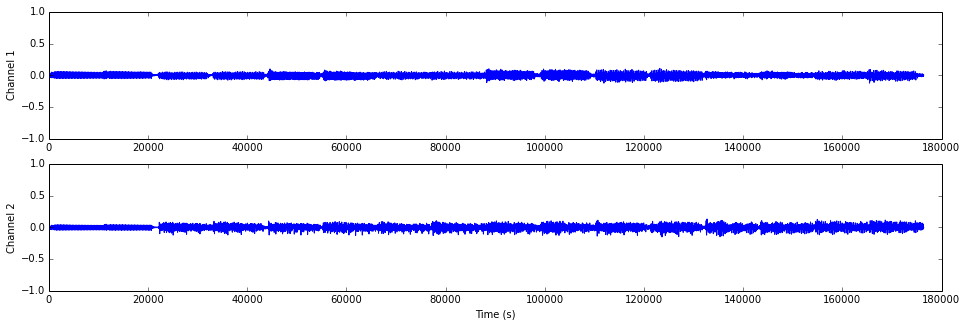

In [8]:
max_samples_plot = 4 * samplerate # limit number of samples to plot (to 4 sec), to avoid graphical overflow

if nsamples < max_samples_plot:
    max_samples_plot = nsamples

plot_waveform(wavedata[0:max_samples_plot], 16, 5);

### Audio Pre-processing

For audio processing and feature extraction, we use a single channel only.

Therefore in case we have a stereo signal, we combine the separate channels:

In [9]:
# use combine the channels by calculating their geometric mean
wavedata_mono = np.mean(wavedata, axis=1)

Below an example waveform of a mono channel after combining the stereo channels by arithmetic mean:

Plotting Mono


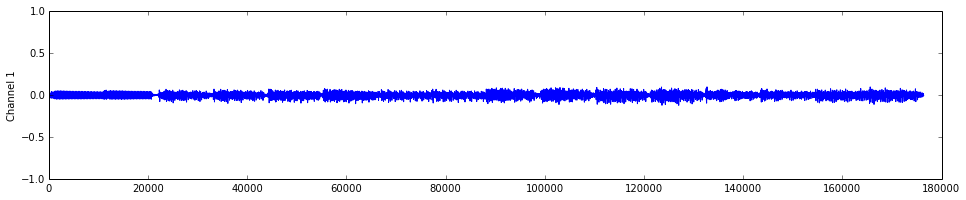

In [10]:
plot_waveform(wavedata_mono[0:max_samples_plot], 16, 3)

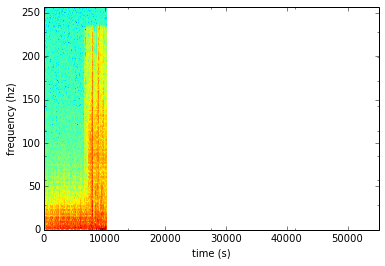

In [11]:
plotstft(wavedata_mono, samplerate, binsize=512, ignore=True);

# <a name="extraction"><font color="#0404B4">3. Audio Feature Extraction</font></a>

## Rhythm Patterns 

<img width="350" src="http://www.ifs.tuwien.ac.at/mir/audiofeatureextraction/feature_extraction_RP_SSD_RH_web.png" style="float:right;margin-left:20px;margin-bottom:20px">

Rhythm Patterns (also called Fluctuation Patterns) describe modulation amplitudes for a range of modulation frequencies on "critical bands" of the human auditory range, i.e. fluctuations (or rhythm) on a number of frequency bands. The feature extraction process for the Rhythm Patterns is composed of two stages:

First, the specific loudness sensation in different frequency bands is computed, by using a Short Time FFT, grouping the resulting frequency bands to psycho-acoustically motivated critical-bands, applying spreading functions to account for masking effects and successive transformation into the decibel, Phon and Sone scales. This results in a power spectrum that reflects human loudness sensation (Sonogram).

In the second step, the spectrum is transformed into a time-invariant representation based on the modulation frequency, which is achieved by applying another discrete Fourier transform, resulting in amplitude modulations of the loudness in individual critical bands. These amplitude modulations have different effects on human hearing sensation depending on their frequency, the most significant of which, referred to as fluctuation strength, is most intense at 4 Hz and decreasing towards 15 Hz. From that data, reoccurring patterns in the individual critical bands, resembling rhythm, are extracted, which – after applying Gaussian smoothing to diminish small variations – result in a time-invariant, comparable representation of the rhythmic patterns in the individual critical bands.

In [13]:
features = rp_extract(wavedata,                            # the two-channel wave-data of the audio-file
                                samplerate,                          # the samplerate of the audio-file
                                extract_rp          = True,          # <== extract this feature!
                                transform_db        = True,          # apply psycho-accoustic transformation
                                transform_phon      = True,          # apply psycho-accoustic transformation
                                transform_sone      = True,          # apply psycho-accoustic transformation
                                fluctuation_strength_weighting=True, # apply psycho-accoustic transformation
                                skip_leadin_fadeout = 1,             # skip lead-in/fade-out. value = number of segments skipped
                                step_width          = 1)             # 

(24, 60)


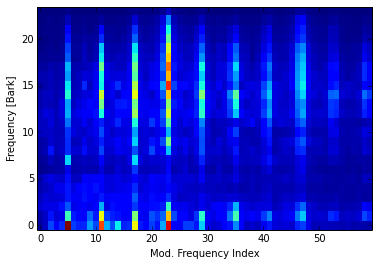

In [14]:
plotrp(features['rp'])

## Statistical Spectrum Descriptor 

The Sonogram is calculated as in the first part of the Rhythm Patterns calculation. According to the occurrence of beats or other rhythmic variation of energy on a specific critical band, statistical measures are able to describe the audio content. Our goal is to describe the rhythmic content of a piece of audio by computing the following statistical moments on the Sonogram values of each of the critical bands:

  * mean, median, variance, skewness, kurtosis, min- and max-value

In [18]:
features = rp_extract(wavedata,                            # the two-channel wave-data of the audio-file
                                samplerate,                          # the samplerate of the audio-file
                                extract_ssd         = True,          # <== extract this feature!
                                transform_db        = True,          # apply psycho-accoustic transformation
                                transform_phon      = True,          # apply psycho-accoustic transformation
                                transform_sone      = True,          # apply psycho-accoustic transformation
                                fluctuation_strength_weighting=True, # apply psycho-accoustic transformation
                                skip_leadin_fadeout = 1,             # skip lead-in/fade-out. value = number of segments skipped
                                step_width          = 1)             # 

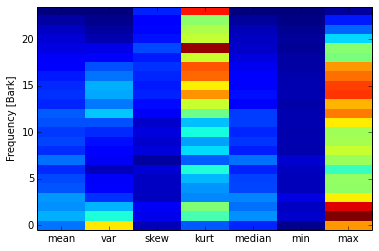

In [19]:
plotssd(features['ssd'])

## Rhythm Histogram

The Rhythm Histogram features we use are a descriptor for general rhythmics in an audio document. Contrary to the Rhythm Patterns and the Statistical Spectrum Descriptor, information is not stored per critical band. Rather, the magnitudes of each modulation frequency bin of all critical bands are summed up, to form a histogram of "rhythmic energy" per modulation frequency. The histogram contains 60 bins which reflect modulation frequency between 0 and 10 Hz. For a given piece of audio, the Rhythm Histogram feature set is calculated by taking the median of the histograms of every 6 second segment processed.

In [20]:
features = rp_extract(wavedata,                            # the two-channel wave-data of the audio-file
                                samplerate,                          # the samplerate of the audio-file
                                extract_rh          = True,          # <== extract this feature!
                                transform_db        = True,          # apply psycho-accoustic transformation
                                transform_phon      = True,          # apply psycho-accoustic transformation
                                transform_sone      = True,          # apply psycho-accoustic transformation
                                fluctuation_strength_weighting=True, # apply psycho-accoustic transformation
                                skip_leadin_fadeout = 1,             # skip lead-in/fade-out. value = number of segments skipped
                                step_width          = 1)             # 

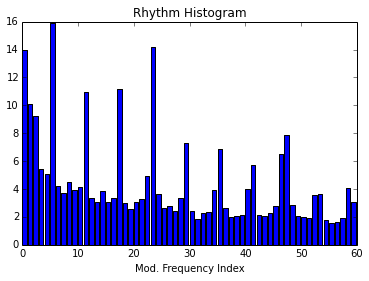

In [21]:
plotrh(features['rh'])

### Get rough BPM from Rhythm Histogram

By looking at the maximum peak of a Rhythm Histogram, we can determine the beats per minute (BPM) very roughly by multiplying the Index of the Rhythm Histogram bin by the modulation frequency resolution (0.168 Hz) * 60. The resolution of this is however only at +/- 10 bpm.

In [49]:
maxbin = features['rh'].argmax(axis=0) + 1  # +1 because it starts from 0

mod_freq_res = 1.0 / (2**18/44100.0)  # resolution of modulation frequency axis (0.168 Hz) (= 1/(segment_size/samplerate))
#print mod_freq_res * 60 # resolution

bpm = maxbin * mod_freq_res * 60

print bpm

60.5621337891


## Modulation Frequency Variance Descriptor 

This descriptor measures variations over the critical frequency bands for a specific modulation frequency (derived from a rhythm pattern).

Considering a rhythm pattern, i.e. a matrix representing the amplitudes of 60 modulation frequencies on 24 critical bands, an MVD vector is derived by computing statistical measures (mean, median, variance, skewness, kurtosis, min and max) for each modulation frequency over the 24 bands. A vector is computed for each of the 60 modulation frequencies. Then, an MVD descriptor for an audio file is computed by the mean of multiple MVDs from the audio file's segments, leading to a 420-dimensional vector. 

## Temporal Statistical Spectrum Descriptor 

Feature sets are frequently computed on a per segment basis and do not incorporate time series aspects. As a consequence, TSSD features describe variations over time by including a temporal dimension. Statistical measures (mean, median, variance, skewness, kurtosis, min and max) are computed over the individual statistical spec- trum descriptors extracted from segments at different time positions within a piece of audio. This captures timbral variations and changes over time in the audio spectrum, for all the critical Bark-bands. Thus, a change of rhythmic, instruments, voices, etc. over time is reflected by this feature set. The dimension is 7 times the dimension of an SSD (i.e. 1176).

## Temporal Rhythm Histograms

Statistical measures (mean, median, variance, skewness, kurtosis, min and max) are computed over the individual Rhythm Histograms extracted from various segments in a piece of audio. Thus, change and variation of rhythmic aspects in time are captured by this descriptor. 

### Extract All Features

To extract ALL or selected ones of the before described features, you can use this command: 

In [ ]:
# adapt the fext array to your needs:
fext = ['rp','ssd','rh','mvd'] # sh, tssd, trh

features = rp_extract(wavedata,
                  samplerate,
                  extract_rp   = ('rp' in fext),          # extract Rhythm Patterns features
                  extract_ssd  = ('ssd' in fext),           # extract Statistical Spectrum Descriptor
                  extract_sh   = ('sh' in fext),          # extract Statistical Histograms
                  extract_tssd = ('tssd' in fext),          # extract temporal Statistical Spectrum Descriptor
                  extract_rh   = ('rh' in fext),           # extract Rhythm Histogram features
                  extract_trh  = ('trh' in fext),          # extract temporal Rhythm Histogram features
                  extract_mvd  = ('mvd' in fext),        # extract Modulation Frequency Variance Descriptor
                  spectral_masking=True,
                  transform_db=True,
                  transform_phon=True,
                  transform_sone=True,
                  fluctuation_strength_weighting=True,
                  skip_leadin_fadeout=1,
                  step_width=1)

In [29]:
# let's see what we got in our dict
print features.keys()

['ssd', 'rh', 'rp', 'mvd']


In [33]:
# list the feature type dimensions

for k in features.keys():
    print k, features[k].shape


ssd (168,)
rh (60,)
rp (1440,)
mvd (420,)


# <a name="application"><font color="#0404B4">4. Application Scenarios</font></a>

## Analyze Songs from Soundcloud

In this step we are going to analyze songs from Soundcloud, using the Soundcloud API.

Please get your own API key first by clicking "Register New App" on <a href="https://developers.soundcloud.com">https://developers.soundcloud.com</a>.

Then we can start using the Soundcloud API:

In [53]:
# START SOUNDCLOUD API
import soundcloud

# To use soundcloud-python, you must first create a Client instance, passing at a minimum the client id you 
# obtained when you registered your app:

# If you only need read-only access to public resources, simply provide a client id when creating a Client instance:
my_client_id= 'insert your Client ID from Soundcloud here'
my_client_id= '2efefe769cabf9cb146b1349591de8bf'
#my_client_id= 'b94ef2ab2e117eba662d31081d385226'

client = soundcloud.Client(client_id=my_client_id)
# if there is no error after this, it should have worked

In these application scenarios we try to find similar songs or classify music into different categories.

For these Use Cases we need to import a few additional functions from the sklearn package and from mir_utils (installed from git above in parallel to rp_extract):

In [2]:
# IMPORTING mir_utils (installed from git above in parallel to rp_extract (otherwise ajust path))
import sys
sys.path.append("../mir_utils")
from demo.NotebookUtils import *
from demo.PlottingUtils import *
from demo.Soundcloud_Demo_Dataset import SoundcloudDemodatasetHandler

In [3]:
# IMPORTS for Classification and Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## The Soundcloud Demo Dataset

The Soundcloud Demo Dataset is a collection of commonly known mainstream radio songs hosted on the online streaming platform Soundcloud. The Dataset is available as playlist and is intended to be used to demonstrate the performance of MIR algorithms with the help of well known songs.

<iframe width="100%" height="450" scrolling="no" frameborder="no" src="https://w.soundcloud.com/player/?url=https%3A//api.soundcloud.com/playlists/106852365&amp;auto_play=false&amp;hide_related=false&amp;show_comments=true&amp;show_user=true&amp;show_reposts=false&amp;visual=true"></iframe>

The *SoundcloudDemodatasetHandler* abstracts the access to the TU-Wien server. On this server the extracted features are stored as csv-files. The *SoundcloudDemodatasetHandler* remotely loads the features and returns them by request. The features have been extracted using the method explained in the previous sections.

In [35]:
scds = SoundcloudDemodatasetHandler("D:/Research/Data/MIR/Soundcloud_Dataset", lazy=True)

## <a name="similar"><font color="#0404B4">4.1. Finding Similar Sounding Songs</font></a>

The query-song:

In [ ]:
query_track_soundcloud_id = 68687842

HTML(scds.getPlayerHTMLForID(query_track_soundcloud_id))

Fitting the siilarity search object

In [21]:
sim_song_search = NearestNeighbors(n_neighbors = 6, metric='euclidean')

### Finding rhythmical similar songs

##### Finding rhythmical similar songs using Rhythm Histograms

In [22]:
feature_set = 'rh'

Normalize the extracted features.

In [23]:
scaled_feature_space = StandardScaler().fit_transform(rp_features[feature_set]["data"])

Fit the Nearest-Neighbor search object to the extracted features

In [24]:
sim_song_search.fit(scaled_feature_space);

Retrieve the feature vector for the query song

In [25]:
query_track_feature_vector = scaled_feature_space[rp_features[feature_set]["soundcloudids"] == query_track_soundcloud_id]

Search the nearest neighbors of the query-feature-vector

In [26]:
similar_songs = sim_song_search.kneighbors(query_track_feature_vector, return_distance=False)[0]

Because we are searching in the entire collection, the top-most result is the query song itself. Thus, we can skip it.

In [27]:
similar_songs = similar_songs[1:]

Lookup the corresponding Soundcloud-IDs

In [28]:
similar_soundcloud_ids = rp_features[feature_set]["soundcloudids"][similar_songs]

Listen to the results

In [39]:
SoundcloudTracklist(similar_soundcloud_ids, width=90, height=120, visual=False)

""
""
""
""
""


##### Finding rhythmical similar songs using Rhythm Patterns

In [40]:
def search_similar_songs(query_song_id, feature_set, skip_query=True):

    #
    scaled_feature_space = StandardScaler().fit_transform(rp_features[feature_set]["data"])

    #
    sim_song_search.fit(scaled_feature_space);

    #
    query_track_feature_vector = scaled_feature_space[rp_features[feature_set]["soundcloudids"] == query_song_id]

    #
    similar_songs = sim_song_search.kneighbors(query_track_feature_vector, return_distance=False)[0]
    
    if skip_query:
        similar_songs = similar_songs[1:]

    #
    similar_soundcloud_ids = rp_features[feature_set]["soundcloudids"][similar_songs]
    
    return similar_soundcloud_ids

In [41]:
similar_soundcloud_ids = search_similar_songs(query_track_soundcloud_id, 
                                              feature_set='rp')

SoundcloudTracklist(similar_soundcloud_ids, width=90, height=120, visual=False)

""
""
""
""
""


### Finding songs based on timbral similarity

##### Finding songs based on timbral similarity using Statistical Spectral Descriptors

In [42]:
similar_soundcloud_ids = search_similar_songs(query_track_soundcloud_id, 
                                              feature_set='ssd')

SoundcloudTracklist(similar_soundcloud_ids, width=90, height=120, visual=False)

""
""
""
""
""


First entry is query-track (TODO: change CSS style of query table cells!)

In [43]:
results_track_1 = search_similar_songs(68687842, feature_set='ssd', skip_query=False)
results_track_2 = search_similar_songs(40439758, feature_set='rh', skip_query=False)

compareSimilarityResults([results_track_1, results_track_2],
                          width=100, height=120, visual=False,
                          columns=['Statistical Spectrum Descriptors', 'Rhythm Histograms'])

Statistical Spectrum Descriptors,Rhythm Histograms
,
,
,
,
,
,


### Combining different Music Descriptors

In [45]:
def search_similar_songs_with_combined_sets(scds, query_song_id, feature_sets, skip_query=True, n_neighbors=6):
    
    features = scds.getCombinedFeaturesets(feature_sets)
    
    sim_song_search = NearestNeighbors(n_neighbors = n_neighbors, metric='l2')

    #
    scaled_feature_space = StandardScaler().fit_transform(features)

    #
    sim_song_search.fit(scaled_feature_space);

    #
    query_track_feature_vector = scaled_feature_space[scds.getFeatureIndexByID(query_song_id, feature_sets[0])]
    
    #
    similar_songs = sim_song_search.kneighbors(query_track_feature_vector, return_distance=False)[0]
    
    if skip_query:
        similar_songs = similar_songs[1:]

    #
    similar_soundcloud_ids = scds.getIdsByIndex(similar_songs, feature_sets[0])
    
    return similar_soundcloud_ids

In [47]:
feature_sets = ['ssd','rh']

compareSimilarityResults([search_similar_songs_with_combined_sets(scds, 68687842, feature_sets=feature_sets, n_neighbors=5),
                          search_similar_songs_with_combined_sets(scds, 40439758, feature_sets=feature_sets, n_neighbors=5)],
                          width=100, height=120, visual=False,
                          columns=[scds.getNameByID(68687842),
                                   scds.getNameByID(40439758)])

Mr Saxobeat,Papa roach - Last Resort
,
,
,
,


# Further Reading

 * [Audio Feature Extraction site of the MIR-Team @TU-Wien](http://www.ifs.tuwien.ac.at/mir/audiofeatureextraction.html)
 * Blog-post: [A gentle Introduction to Music Information Retrieval](http://www.europeanasounds.eu/news/a-gentle-introduction-to-music-information-retrieval-making-computers-understand-music)
 * [Same Blog-post with Python code](http://wwwnew.schindler.eu.com/blog/mir_intro/blog_with_code.html)